# Data preparation/exploration for the Aguathon

## Problem definition

Find the best model that predict the level of the Evro river when cros Zaragoza.

----

## Index

1. [Import modules and data](#first-bullet)
2. [Data exploration](#second-bullet)
3. [Feature Engineering](#third-bullet)
4. [Feature selection](#fourth-bullet)
5. [Missing Values, Split and Scale](#fifth-bullet)
   * Scale-Normaliza values
   * Split the data in train and test set
   
6. [Model regressor](#sixth-bullet)
    * Cross-validation

## Import modules and data <a class="anchor" id="first-bullet"></a>

In [1]:
%load_ext autoreload
%matplotlib inline
#%matplotlib notebook
%autoreload 1


# STD lib imports
import os
import sys

# Third party libs
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from xgboost import plot_importance

# Tensorflow stuff
import keras
import tensorflow as tf
from keras import layers
from keras.layers import Dense

# sklear stuff
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# root path of the project
PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.make_dataset
%aimport features.build_features
%aimport visualization.visualize
import data.make_dataset as md
import features.build_features as bf
import visualization.visualize as vs

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print(os.path.abspath(PROJ_ROOT))

# Load data from ITA
raw_file = 'datos.csv'
path = '../ENTRADA/'
df_raw = md.load_data(path, raw_file)

# Keep Riesgo for future evaluation
RIESGO = df_raw['RIESGO']

# Drop Grisen and RIESGO base on previous data exploration
df_raw = df_raw.drop(['GRISEN_NR'], axis=1)
df_raw = df_raw.drop(['RIESGO'], axis=1)

# period of the data
start = df_raw.index.min()
end = df_raw.index.max()

idx = df_raw.resample('D').mean().index
print('Shape:', df_raw.shape)
display(df_raw.head())

Using TensorFlow backend.


/Users/miloc/Documents/git-hub/Apsu
Shape: (95856, 8)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,pred_24h,pred_48h,pred_72h
time,,,,,,,,
2008-01-01 00:00:00,0.8100,1.6000,0.2675,0.7875,0.74,0.750,0.7400,0.76
2008-01-01 01:00:00,0.8100,1.6075,0.2650,0.7900,0.74,0.745,0.7325,0.76
2008-01-01 02:00:00,0.8100,1.6100,0.2675,0.7900,0.74,0.740,0.7300,0.76
2008-01-01 03:00:00,0.8075,1.6100,0.2600,0.7900,0.74,0.740,0.7200,0.76
2008-01-01 04:00:00,0.8000,1.6025,0.2650,0.7900,0.74,0.740,0.7200,0.76


In [2]:
# Estation to load data
estaciones = {'pna': '9262-19530901-20190131.csv',  
              'zar_aero':'9434-19410101-20190302.csv'}

# inputs
cols = ['FECHA','TMEDIA','TMIN','TMAX','PRECIPITACION']
path_meteo = '../data/AEMET/DatosPorEstacion/'

# Load meteo data and filter by period
df_meteo = md.load_meteo(path_meteo, estaciones, cols) 
    
# complete hourly data
df_meteo = df_meteo.resample('H').ffill()/24

# Filter by period
df_meteo = df_meteo[(df_meteo.index >= start) & (df_meteo.index <= end)]

print('Shape:', df_meteo.shape)
display(df_meteo.tail())

Shape: (95856, 8)


,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
FECHA,,,,,,,,
2018-12-07 19:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [3]:
# Load data from SAHIEBRO
path_ebro = '../data/SAIHEBRO/'
features = ['AFORO', 'PRECIPITACION', 'TEMPERATURA']
stations = ['A001', 'A002', 'A005', 'A011', 'EM75']
variables = ['NRIO1', 'PACUM', 'TEMPE']

df_ebro = md.load_ebro(path_ebro, features, stations, variables, start, end)

print('Shape:', df_ebro.shape)
display(df_ebro.head())

Shape: (95856, 17)


,A001-L17-NRIO1_VALOR_MAX,A001-L17-NRIO1_VALOR_MIN,A001-L17-NRIO1_VALOR_MED,A002-T17-NRIO1_VALOR_MAX,A002-T17-NRIO1_VALOR_MIN,A002-T17-NRIO1_VALOR_MED,A005-E17-NRIO1_VALOR_MAX,A005-E17-NRIO1_VALOR_MIN,A005-E17-NRIO1_VALOR_MED,A011-Z17-NRIO1_VALOR_MAX,A011-Z17-NRIO1_VALOR_MIN,A011-Z17-NRIO1_VALOR_MED,A005-E84-PACUM_VALOR_MAX,EM75-E84-PACUM_VALOR_MAX,EM75-E02-TEMPE_VALOR_MAX,EM75-E02-TEMPE_VALOR_MIN,EM75-E02-TEMPE_VALOR_MED
FECHA,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,0.038333,0.029583,0.035417,NaN,NaN,NaN,0.015833,0.014583,0.015417,0.03125,0.030833,0.03125,0.0,NaN,NaN,NaN,NaN
2008-01-01 01:00:00,0.038333,0.029583,0.035417,NaN,NaN,NaN,0.015833,0.014583,0.015417,0.03125,0.030833,0.03125,0.0,NaN,NaN,NaN,NaN
2008-01-01 02:00:00,0.038333,0.029583,0.035417,NaN,NaN,NaN,0.015833,0.014583,0.015417,0.03125,0.030833,0.03125,0.0,NaN,NaN,NaN,NaN
2008-01-01 03:00:00,0.038333,0.029583,0.035417,NaN,NaN,NaN,0.015833,0.014583,0.015417,0.03125,0.030833,0.03125,0.0,NaN,NaN,NaN,NaN
2008-01-01 04:00:00,0.038333,0.029583,0.035417,NaN,NaN,NaN,0.015833,0.014583,0.015417,0.03125,0.030833,0.03125,0.0,NaN,NaN,NaN,NaN


In [4]:
# Concatenate both data frames
df = pd.concat([df_raw, df_meteo, df_ebro], axis=1)
#df = df_raw.copy(deep=True)

print('Shape:', df.shape)
display(df.tail())

Shape: (95856, 33)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,pred_24h,pred_48h,pred_72h,TMEDIA_pna,TMIN_pna,...,A005-E17-NRIO1_VALOR_MIN,A005-E17-NRIO1_VALOR_MED,A011-Z17-NRIO1_VALOR_MAX,A011-Z17-NRIO1_VALOR_MIN,A011-Z17-NRIO1_VALOR_MED,A005-E84-PACUM_VALOR_MAX,EM75-E84-PACUM_VALOR_MAX,EM75-E02-TEMPE_VALOR_MAX,EM75-E02-TEMPE_VALOR_MIN,EM75-E02-TEMPE_VALOR_MED
FECHA,,,,,,,,,,,,,,,,,,,,,
2018-12-07 19:00:00,0.9850,1.7300,0.52,0.8450,1.05,1.03,1.0,0.99,NaN,0.033333,...,0.005833,0.011667,0.045417,0.044583,0.045,0.0,0.0,0.516667,0.0,0.3
2018-12-07 20:00:00,0.9800,1.7475,0.52,0.8450,1.05,1.03,1.0,0.99,NaN,0.033333,...,0.005833,0.011667,0.045417,0.044583,0.045,0.0,0.0,0.516667,0.0,0.3
2018-12-07 21:00:00,0.9675,1.7500,0.52,0.8375,1.05,1.03,1.0,0.99,NaN,0.033333,...,0.005833,0.011667,0.045417,0.044583,0.045,0.0,0.0,0.516667,0.0,0.3
2018-12-07 22:00:00,0.9550,1.7400,0.52,0.8300,1.05,1.03,1.0,0.99,NaN,0.033333,...,0.005833,0.011667,0.045417,0.044583,0.045,0.0,0.0,0.516667,0.0,0.3
2018-12-07 23:00:00,0.9450,1.7375,0.52,0.8300,1.05,1.03,1.0,0.99,NaN,0.033333,...,0.005833,0.011667,0.045417,0.044583,0.045,0.0,0.0,0.516667,0.0,0.3


## Data exploration <a class="anchor" id="second-bullet"></a>

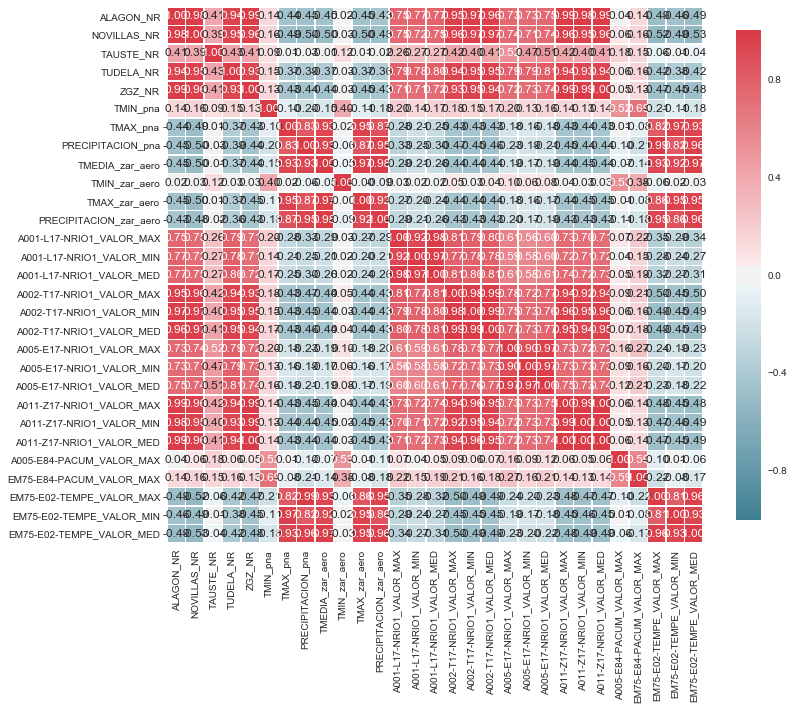

In [5]:
vs.corr_heatmap(pd.concat([df.iloc[:,:5], df.iloc[:,9:]], axis=1))

## Feature engineering <a class="anchor" id="third-bullet"></a>

In [6]:
# Features
columns_y = ['pred_24h', 'pred_48h', 'pred_72h']
columns_x = [x for x in df.columns if x not in columns_y]

X = df[columns_x]
Y = df[columns_y[2]]

# Create features base on delta to time
cols_delt = columns_x[:5]
X = bf.delta_height(X, cols_delt, 1, True)
X = bf.delta_height(X, cols_delt, 5, True)

# number of derived columns per feature
N = 1  

# time delta in hr
delta = [8, 145]

# Create new shifted features
dup_cols = ['TUDELA_NR', 'NOVILLAS_NR']
X = bf.column_shift(X, dup_cols, N, delta[0])

dup_cols = ['ALAGON_NR', 'ZGZ_NR']
X = bf.column_shift(X, dup_cols, N, delta[1]) 

print('Shape:', X.shape)
display(X.head())

Shape: (95850, 44)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,...,delta_1_ZGZ_NR,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR,TUDELA_NR_8,NOVILLAS_NR_8,ALAGON_NR_145,ZGZ_NR_145
FECHA,,,,,,,,,,,,,,,,,,,,,
2008-01-01 06:00:00,0.800,1.590,0.2600,0.7825,0.7425,0.083333,0.0,-0.158333,0.329167,-0.058333,...,-0.0025,0.0020,0.0035,0.0010,0.0015,-0.0005,NaN,NaN,NaN,NaN
2008-01-01 07:00:00,0.795,1.590,0.2525,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,-0.0075,0.0030,0.0040,0.0030,0.0020,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 08:00:00,0.790,1.595,0.2550,0.7750,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0035,0.0030,0.0010,0.0030,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 09:00:00,0.790,1.600,0.2525,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0020,0.0005,0.0025,0.0020,-0.0020,NaN,NaN,NaN,NaN
2008-01-01 10:00:00,0.790,1.610,0.2550,0.7800,0.7500,0.083333,0.0,-0.158333,0.329167,-0.058333,...,0.0000,0.0020,-0.0030,0.0005,0.0020,-0.0020,NaN,NaN,NaN,NaN


## Missing Values, Split and Scale <a class="anchor" id="fifth-bullet"></a>

In [7]:
X.isnull().sum()

ALAGON_NR                   16968
NOVILLAS_NR                  1468
TAUSTE_NR                     519
TUDELA_NR                     277
ZGZ_NR                          0
TMEDIA_pna                     48
TMIN_pna                       24
TMAX_pna                       24
PRECIPITACION_pna              24
TMEDIA_zar_aero                 0
TMIN_zar_aero                   0
TMAX_zar_aero                   0
PRECIPITACION_zar_aero          0
A001-L17-NRIO1_VALOR_MAX      168
A001-L17-NRIO1_VALOR_MIN      168
A001-L17-NRIO1_VALOR_MED      168
A002-T17-NRIO1_VALOR_MAX      138
A002-T17-NRIO1_VALOR_MIN      138
A002-T17-NRIO1_VALOR_MED      138
A005-E17-NRIO1_VALOR_MAX     3648
A005-E17-NRIO1_VALOR_MIN     3648
A005-E17-NRIO1_VALOR_MED     3648
A011-Z17-NRIO1_VALOR_MAX      120
A011-Z17-NRIO1_VALOR_MIN      120
A011-Z17-NRIO1_VALOR_MED      120
A005-E84-PACUM_VALOR_MAX      264
EM75-E84-PACUM_VALOR_MAX     4266
EM75-E02-TEMPE_VALOR_MAX     3906
EM75-E02-TEMPE_VALOR_MIN     3906
EM75-E02-TEMPE

In [8]:
# Most simple thing, remove missing values
X = X.dropna()
Y = Y[X.index]
X.isnull().sum()

ALAGON_NR                   0
NOVILLAS_NR                 0
TAUSTE_NR                   0
TUDELA_NR                   0
ZGZ_NR                      0
TMEDIA_pna                  0
TMIN_pna                    0
TMAX_pna                    0
PRECIPITACION_pna           0
TMEDIA_zar_aero             0
TMIN_zar_aero               0
TMAX_zar_aero               0
PRECIPITACION_zar_aero      0
A001-L17-NRIO1_VALOR_MAX    0
A001-L17-NRIO1_VALOR_MIN    0
A001-L17-NRIO1_VALOR_MED    0
A002-T17-NRIO1_VALOR_MAX    0
A002-T17-NRIO1_VALOR_MIN    0
A002-T17-NRIO1_VALOR_MED    0
A005-E17-NRIO1_VALOR_MAX    0
A005-E17-NRIO1_VALOR_MIN    0
A005-E17-NRIO1_VALOR_MED    0
A011-Z17-NRIO1_VALOR_MAX    0
A011-Z17-NRIO1_VALOR_MIN    0
A011-Z17-NRIO1_VALOR_MED    0
A005-E84-PACUM_VALOR_MAX    0
EM75-E84-PACUM_VALOR_MAX    0
EM75-E02-TEMPE_VALOR_MAX    0
EM75-E02-TEMPE_VALOR_MIN    0
EM75-E02-TEMPE_VALOR_MED    0
delta_1_ALAGON_NR           0
delta_1_NOVILLAS_NR         0
delta_1_TAUSTE_NR           0
delta_1_TU

### Scale-Normaliza values

In [9]:
# MinMax scale
scaler = MinMaxScaler()
columnas = X.columns
indices = X.index
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columnas, index=indices)

### Split the data in train and test set

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(x_train.shape)
display(x_train.head())

(48291, 44)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,...,delta_1_ZGZ_NR,delta_5_ALAGON_NR,delta_5_NOVILLAS_NR,delta_5_TAUSTE_NR,delta_5_TUDELA_NR,delta_5_ZGZ_NR,TUDELA_NR_8,NOVILLAS_NR_8,ALAGON_NR_145,ZGZ_NR_145
FECHA,,,,,,,,,,,,,,,,,,,,,
2010-07-03 13:00:00,0.093290,0.130348,0.038020,0.058290,0.067496,0.763889,0.0,0.759375,0.721311,0.835329,...,0.739837,0.649718,0.726953,0.661754,0.513889,0.702643,0.053512,0.122056,0.095254,0.074600
2009-10-18 18:00:00,0.054010,0.053400,0.012195,0.034878,0.058615,0.400000,0.0,0.384375,0.386417,0.398204,...,0.739837,0.661017,0.755926,0.656595,0.525463,0.685022,0.032489,0.062687,0.065794,0.062167
2009-12-30 03:00:00,0.268740,0.320398,0.029412,0.138079,0.197158,0.438889,0.0,0.487500,0.379391,0.419162,...,0.756098,0.645198,0.736611,0.656595,0.493056,0.711454,0.127090,0.321061,0.079214,0.069272
2013-04-17 09:00:00,0.386907,0.413599,0.052367,0.190158,0.278863,0.691667,0.0,0.606250,0.714286,0.646707,...,0.731707,0.638418,0.743635,0.659543,0.537037,0.676211,0.188247,0.419237,0.534861,0.397425
2013-06-11 10:00:00,0.772831,0.888226,0.110473,0.565217,0.490231,0.666667,0.0,0.659375,0.634660,0.703593,...,0.617886,0.455367,0.771730,0.658069,0.796296,0.504405,0.634018,0.892206,0.313584,0.251776


## Model regressor <a class="anchor" id="sixth-bullet"></a>

In [11]:
# Display training progress by printing a single dot for each completed epoch
EPOCHS = 1000
seed = 7

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(X, Y):
    model = keras.Sequential([
        layers.Dense(128, kernel_initializer='normal', activation=tf.nn.relu, input_shape=[len(X.keys())]),
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(1, kernel_initializer='normal', activation='linear')
        ])

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    history = model.fit(X.values[train], 
                        Y.values[train], 
                        epochs=EPOCHS,
                        batch_size=32,
                        validation_split = 0.2, 
                        verbose=0, 
                        callbacks=[early_stop])
    
    scores = r2(Y.values[test], model.predict(X.values[test]))
    print('r2: %.2f%%' % (scores*100))
    cvscores.append(scores * 100)
    
cvscores = np.array(cvscores)

r2: 97.49%
r2: 97.51%
r2: 97.74%
r2: 97.45%
r2: 97.63%
r2: 97.55%
r2: 97.78%
r2: 97.23%
r2: 97.07%
r2: 98.00%


In [12]:
print('Accuracy: %0.2f (+/- %0.2f)' % (cvscores.mean(), cvscores.std() * 2))
print('Confidence interval 95%')

Accuracy: 97.55 (+/- 0.51)
Confidence interval 95%


In [13]:
model = keras.Sequential([
        layers.Dense(128, kernel_initializer='normal', activation=tf.nn.relu, input_shape=[len(X.keys())]),
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(1, kernel_initializer='normal', activation='linear')
        ])

model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error', 'mean_squared_error'])

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, 
                    y_train, 
                    epochs=1000,
                    batch_size=32,
                    validation_split = 0.2, 
                    verbose=0, 
                    callbacks=[early_stop])

score = r2(y_test, model.predict(x_test))
print('r2: %.2f%%' % (score*100))

r2: 98.89%


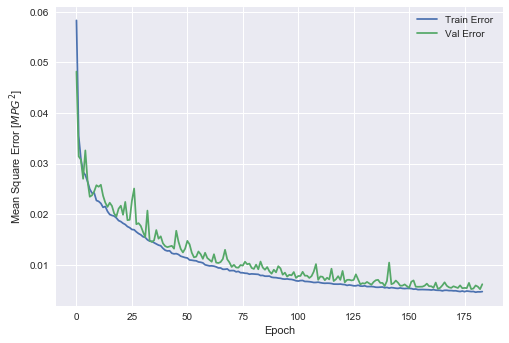

In [14]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    plt.legend()
    plt.show()

plot_history(history)

In [15]:
score = r2(y_test[RIESGO.loc[x_test.index].values == True], model.predict(x_test[RIESGO.loc[x_test.index].values == True]))
print('r2: %.2f%%' % (score*100))

r2: 98.16%


In [16]:
score = r2(y_train[RIESGO.loc[x_train.index].values == True], model.predict(x_train[RIESGO.loc[x_train.index].values == True]))
print('r2: %.2f%%' % (score*100))

r2: 98.54%
